In [190]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [191]:
from konlpy.tag import Okt, Kkma, Mecab, Hannanum
okt = Okt()
kkma = Kkma()
hannanum = Hannanum()
# mecab = Mecab() # mecab은 윈도우에서 사용 불가

# 입력데이터

In [192]:
df = pd.read_csv('8529_data_full.csv', sep='\t', encoding='UTF-8')

In [184]:
df.columns

Index(['std_clm_type_cd', 'ro_y', 'clm_jgmt_dt', 'ceq_caus_cd', 'ceq_psit_cd',
       'ceq_psit_nm', 'trim_plnt_cd', 'prj_vehl_cd', 'mdl_cd', 'part_sys_cd',
       'repn_part_cd', 'clm_prtl_sbc', '대상 선정', '구분', '책임구', '원인', '검토결과'],
      dtype='object')

In [185]:
df.head()

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd    ceq_psit_nm  \
0               W  2017     20170811         ZZ7         B11  조립 문제_미장착/오장착   
1               W  2018     20180822         ZZ7         B11  조립 문제_미장착/오장착   
2               W  2018     20181006         ZZ5         B11  조립 문제_미장착/오장착   
3               W  2018     20180928         ZZ7         B11  조립 문제_미장착/오장착   
4               W  2016     20160526         ZZ5         B11  조립 문제_미장착/오장착   

  trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd repn_part_cd  \
0         KV11          CK     J5          TT        82305   
1         KV11          YP     A9          TT        84211   
2         KV11          YP     A9          TT        83912   
3         KV11          YP     A9          TT        83120   
4         KV11          YP     A9          TT        83860   

                                        clm_prtl_sbc 대상 선정   구분  책임구   원인  \
0  [C] 1.현상:엔진룸 다량의 연료 누유 발생.2.점검:엔진룸 다량의 연료 누유 점...     X  NaN  NaN  NaN   
1                       [C] 1.현상: 리어 도어 앤티 취핑 필림 미장착     X  NaN  NaN  NaN   
2  [C] 1.현상:Rr RH 커튼 후크  미장착 출고됨.2.조치내용:Rr RH 커튼 ...     X  NaN  NaN  NaN   
3              [C] 현상및조치   차량출고시 웨즈스트립고무 주름발생 들뜸교환조치     X  NaN  NaN  NaN   
4                     [C] 몰딩 내부 고무 미조립 상태에서 몰딩 조립 출고     X  NaN  NaN  NaN   

   검토결과  
0  X---  
1  X---  
2  X---  
3  X---  
4  X---

In [186]:
df.shape

(8529, 17)

# 분류현황

In [139]:
category_count = df['검토결과'].value_counts()
category_count

X---                    5517
O-기능(커넥터)-구매-부품         1288
O-실내부품이음-구매-부품           737
O-하체이음-구매-부품             249
O-기능(커넥터)-생산공장-결선불량      225
O-실내부품이음-생산공장-조립불량       204
O-실내부품이음-생산공장-체결불량        70
O-하체이음-생산공장-기타            53
O-기능(커넥터)-생산공장-미결선        37
O-하체이음-생산공장-체결불량          33
O-기능(커넥터)-생산공장-기타         30
O-하체이음-생산공장-조립불량          26
O-기능(커넥터)-생산공장-이종/간섭      21
O-실내부품이음-생산공장-기타          17
O-실내부품이음-연구소-설계/구조        14
O-실내부품이음-생산공장-이물           8
Name: 검토결과, dtype: int64

# null값 처리

In [193]:
# 제거
# df = df[df['대상 선정'].notnull()].copy()
# 다른값으로 채우기
df = df.fillna('N')

# 전처리

In [194]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
# df['result_pred'] = df['검토결과'].astype(str).copy()
df['target_pred'] = df['대상 선정'].astype(str).copy()
# df['charge_pred'] = df['책임구'].astype(str).copy()

In [188]:
def nouns(text):
    text = okt.nouns(text)
    return text

In [189]:
df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(nouns)

RuntimeError: No matching overloads found for tokenize in find. at native\common\jp_method.cpp:127

In [195]:
def preprocessing(text):
    # 개행문자 제거
    text= str(text)
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    #text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ]', ' ', text) 
    text = re.sub(' +', ' ', text)
    return text

In [196]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['현상', '[C]','현상및점검','현    상','점검점검', '점검내용','조치내용','점검점검내용','현상및조치','C','원인','점검/원인',
'사진첨부','(사진첨부)','사진참조','점검및원인','동영상참조','동영상','대리점','고객','고객에게','상기','차량','상기차량은','자동차',
'당차량은','당차량','당','차량은','점검및조치내용','F/LH','F/RH','L/H','R/H','L/H리어','R/H리어','LH/RH','LH','RH','(RH)','(LH)','R/LH',
'R/RH','리어RH','리어LH','LH쪽','RH쪽','Rr','RR','FRT','Frt','frt','rr','C-10000','C-100','(좌)','(우)','A/S']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words) #stops에 안 걸리는 나머지 것들 이어붙이기

In [197]:
# %time 
df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(preprocessing)

In [198]:
#%time 
df['clm_prtl_sbc'] = df['clm_prtl_sbc'].apply(remove_stopwords)

In [199]:
df['clm_prtl_sbc'].head(15)

0      엔진룸 다량의 연료 누유 발생 점검 엔진룸 다량의 연료 누유 점검 엔진룸 프론트 ...
1                                    리어 도어 앤티 취핑 필림 미장착
2                          커튼 후크 미장착 출고됨 커튼 후크 장착후 출고함 
3                             차량출고시 웨즈스트립고무 주름발생 들뜸교환조치
4                            몰딩 내부 고무 미조립 상태에서 몰딩 조립 출고
5      리어 윈도우 판넬 트립 미장착 내용 출고 후 리어 윈도우 판넬 트립 좌측 미장착됨...
6                  우측 슬라이딩 도어 커튼 도리 미창작으로 입고되어 장착 후 출고함
7            프론트 우측 도어 웨져스터립 미 부착상태로 출고됨 웨져스트립 부착 후 출고함
8      조수석 윗부분 누수로 입고 및 누수테스트기 확인시 조수석위 에어컨 스위치 쪽으로 ...
9      현 상 리어도어 휀더부 얼룩짐으로 불만입고 점검결과 취핑테이프 들뜸으로 인한 내부...
10     파워 슬라이딩 도어 B필라 스위치 작동불량점검 B필라 탈거 후 점검 배선 조립 불...
11     조수석 슬라이딩 도어 탈선 조수석 슬라이딩도어 어퍼롤러 범퍼 미장착으로인한증상 장...
12     가 인도후 오디오 작동시 주파수 및 노이즈 발생으로 불만 제기 및 가 점검 결과 ...
13     프론트 우측 안개등 커버 범퍼와 안개등 커버 단차및 유격발생 외부 충격 및 사고흔...
14     주행중 엔진경고등 점등 및 스캔점검결과 P DPF효율저하 발생됨 임시코드 주행점검...
Name: clm_prtl_sbc, dtype: object

# Traindata Testdata 만들기

In [200]:
df = df.reindex() #index 재설정. reindex:새로운 색인에 맞도록 객체를 새로 생성하는 기능.

In [201]:
df.shape

(8529, 18)

In [202]:
from sklearn.model_selection import train_test_split

In [203]:
df_train_v, df_test_v = train_test_split(df, test_size = 0.1, random_state=123)

In [204]:
df_train = df_train_v.copy()
df_test = df_test_v.copy()

In [205]:
df_train.shape

(7676, 18)

In [206]:
df_test.shape

(853, 18)

# 단어 벡터화

In [207]:
from sklearn.feature_extraction.text import CountVectorizer

stops = ['[C]']
vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = stops, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 1, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 20000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=20000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=['[C]'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [208]:
#%%time 
train_feature_vector = vectorizer.fit_transform(df_train['clm_prtl_sbc'])
train_feature_vector.shape

(7676, 20000)

In [209]:
train_feature_vector[:10]

<10x20000 sparse matrix of type '<class 'numpy.int64'>'
	with 119 stored elements in Compressed Sparse Row format>

In [210]:
#%%time 
test_feature_vector = vectorizer.fit_transform(df_test['clm_prtl_sbc'])
test_feature_vector.shape

(853, 20000)

In [211]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

20000


['abc',
 'abs',
 'abs vdc',
 'adm',
 'aeb',
 'aeb mfc',
 'aeb mfc ldws',
 'ahs',
 'air',
 'air 빼기']

In [212]:
dist = np.sum(train_feature_vector, axis=0)

In [213]:
dist.shape

(1, 20000)

In [214]:
dist_pd = pd.DataFrame(dist, columns=vocab)

In [215]:
dist_pd

abc  abs  abs vdc  adm  aeb  aeb mfc  aeb mfc ldws  ahs  air  air 빼기  ...  \
0   48    3        3   10    4        3             6    3    4       9  ...   

   힌지부위 조수석 대비  힌지의  힌지의 뒤쪽  힌지의 뒤쪽 스톱퍼이  힌지의 스톱퍼  힌지의 스톱퍼 볼트를  힘들었으며  \
0            3   20       4            3        4            8      3   

   힘들었으며 이중철판사이에  힘들었으며 이중철판사이에 이격시켜가며이음수정함  힘있게  
0              5                         21    3  

[1 rows x 20000 columns]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


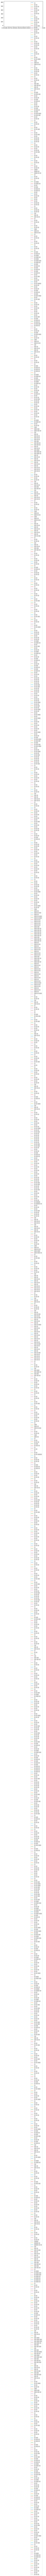

In [131]:
dist.plot(50)

 ...]

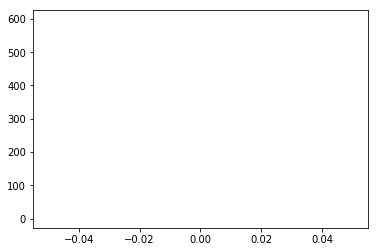

In [130]:
plt.figure(figsize = (6, 4))
plt.plot(dist_pd)
plt.show()

# tf-idf 가중치 적용

In [216]:
# tf-idf(Term Frequency-Inverse Document Frequency). 가중치를 구하는 알고리즘.

In [217]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [218]:
#%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

(7676, 20000)

In [219]:
#%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

(853, 20000)

# 머신러닝 학습

In [220]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [221]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
# y_label2 = df_train['caus_pred']
y_label = df_train['target_pred']
# y_label3 = df_train['charge_pred']
#%time 
forest = forest.fit(train_feature_tfidf, y_label)
# %time forest2 = forest.fit(train_feature_tfidf, y_label2)
# %time forest3 = forest.fit(train_feature_tfidf, y_label3)

# 모델평가

In [222]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score = cross_val_score(forest, train_feature_vector, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

Wall time: 30.5 s


array([0.74609375, 0.74918567, 0.74592834, 0.78371336, 0.75309446])

In [223]:
round(np.mean(score)*100,2)

75.56

# 예측

In [230]:
# 테스트 데이터를 넣고 예측합니다.
y_pred = forest.predict(test_feature_vector)
y_pred[:3]

array(['X', 'O', 'O'], dtype=object)

In [231]:
y_pred.shape

(853,)

In [232]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output = pd.DataFrame(data={'category_pred':y_pred})
output.head(15)

category_pred
0              X
1              O
2              O
3              X
4              X
5              X
6              X
7              O
8              X
9              O
10             X
11             X
12             X
13             X
14             X

In [233]:
df_test['category_pred'] = y_pred

# 결과검증

In [234]:
df_test['pred_diff'] = 0
df_test['pred_diff'] = (df_test['대상 선정'] == df_test['category_pred'] ) == 1
df_test['pred_diff'] = df_test['pred_diff'].astype(int)
df_test.head()

std_clm_type_cd  ro_y  clm_jgmt_dt ceq_caus_cd ceq_psit_cd   ceq_psit_nm  \
8400               W  2015     20151214         ZZ3         V91  차체 진동/떨림_주행중   
2485               W  2015     20150629         ZZ4         I11     작동불량_작동안됨   
6990               W  2017     20170329         ZZ5         Q55     소음/이음_주행중   
5899               W  2017     20171002         ZZ3         Q52    소음/이음_공회전시   
2186               W  2015     20150318         ZZ4         I11     작동불량_작동안됨   

     trim_plnt_cd prj_vehl_cd mdl_cd part_sys_cd repn_part_cd  \
8400         KV11          KH     DH          CC        52910   
2485         KV11          YP     A9          AC        96985   
6990         KV11          YP     A9          CC        58250   
5899         KV11          YP     A9          TT        89600   
2186         KV11          KH     DH          TT        92800   

                                           clm_prtl_sbc 대상 선정       구분 책임구  \
8400   주행중 핸들떨림으로 인한 타이어 바란스 점검바란스 점검시 조그씩 바란스가 틀어짐바...     X        N   N   
2485   클러스터 외기 온도 표시 불량 하여 점검 하니 배선커넥터 정상 학인 되고 외기 온...     O  기능(커넥터)  구매   
6990   주행중 소음으로 입고 및 주행중 뜨드득 소음발생및 후진시 브레이크잠김끌림현상점검 ...     O     하체이음  구매   
5899   시트좌 우 이동시 체결이 되지않아 구리스 및 교정작업을 하였으나 동일현상이 지속이...     X        N   N   
2186                     운전석쪽 무드등 점등 불량으로 오버헤드 콘솔 램프 교환     O  기능(커넥터)  구매   

      원인             검토결과 target_pred category_pred  pred_diff  
8400   N             X---           X             X          1  
2485  부품  O-기능(커넥터)-구매-부품           O             O          1  
6990  부품     O-하체이음-구매-부품           O             O          1  
5899   N             X---           X             X          1  
2186  부품  O-기능(커넥터)-구매-부품           O             X          0

In [235]:
df_test['pred_diff'].sum()

487

In [236]:
487/853

0.570926143024619